In [ ]:
!nvidia-smi

Thu Nov 17 08:11:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 31.7 MB/s 
     |████████████████████████████████| 182 kB 71.4 MB/s 
     |████████████████████████████████| 7.6 MB 55.4 MB/s 


In [ ]:
!pip install -q datasets sentencepiece tensorboard

     |████████████████████████████████| 451 kB 33.2 MB/s 
     |████████████████████████████████| 1.3 MB 15.1 MB/s 
     |████████████████████████████████| 212 kB 67.2 MB/s 
     |████████████████████████████████| 115 kB 68.3 MB/s 
     |████████████████████████████████| 127 kB 57.3 MB/s 


In [ ]:
!sudo apt-get install git-lfs --yes

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [ ]:
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torch torchvision torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!ls

Data  sample_data


In [ ]:
!pwd

/content


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset

# define paths
#base_path = Path("data")
#metadata_path = base_path.joinpath("key")
#image_path = base_path.joinpath("img")
image_path = '/content/Data'

# Load dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")


Resolving data files:   0%|          | 0/198 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-a0472e46f3f79854/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.
Dataset has 197 images
Dataset features are: dict_keys(['image', 'text'])


Random sample is 170
OCR text is {"country_code": "IND", "type": "P", "passport_no": "$6193944", "surname": "SINGH", "given_name": "VIJANDER", "sex": "M", "nationality": "/INDIAN", "date_of_birth": "25/06/1993", "place_of_birth": "BILASPUR, UTTAR PRADESH", "place_of_issue": "BAREILLY", "date_of_issue": "04/10/2018", "date_of_expiry": "03/10/2028"}


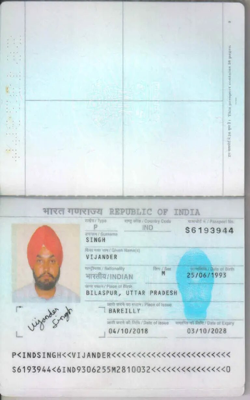

In [ ]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))
#     OCR text is {"company": "LIM SENG THO HARDWARE TRADING", "date": "29/12/2017", "address": "NO 7, SIMPANG OFF BATU VILLAGE, JALAN IPOH BATU 5, 51200 KUALA LUMPUR MALAYSIA", "total": "6.00"}


In [ ]:
import time
start_time = time.time()

In [ ]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")
#    Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
#    New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']


  0%|          | 0/197 [00:00<?, ?ex/s]

Sample: <s><s_type>P</s_type><s_surname>MOHAMMED</s_surname><s_sex>M</s_sex><s_place_of_issue>HYDERABAD</s_place_of_issue><s_place_of_birth>,  FATHENAGAR TELANGANA</s_place_of_birth><s_passport_no>T0631964</s_passport_no><s_nationality>INDIAN</s_nationality><s_given_name>ZAIDUDDIN ASIF</s_given_name><s_date_of_issue>13/03/2019</s_date_of_issue><s_date_of_expiry>12/03/2024</s_date_of_expiry><s_date_of_birth>10/10/2009</s_date_of_birth><s_country_code>IND</s_country_code></s>
New special tokens: ['<s_place_of_issue>', '</s_place_of_issue>', '<s_place_of_birth>', '</s_place_of_birth>', '<s_passport_no>', '</s_passport_no>', '<s_nationality>', '</s_nationality>', '<s_given_name>', '</s_given_name>', '<s_date_of_issue>', '</s_date_of_issue>', '<s_date_of_expiry>', '</s_date_of_expiry>', '<s_date_of_birth>', '</s_date_of_birth>', '<s_country_code>', '</s_country_code>', '<s_type>', '</s_type>', '<s_surname>', '</s_surname>', '<s_sex>', '</s_sex>', '<s>', '</s>']


In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 137.6685914993286 seconds ---


In [ ]:
from transformers import DonutProcessor

# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
#processor.feature_extractor.size = [720,960] # should be (width, height)
processor.feature_extractor.size = [960,1280] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False


Downloading:   0%|          | 0.00/362 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/518 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/355 [00:00<?, ?B/s]

In [ ]:
import time
start_time = time.time()

In [ ]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}

    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])


  0%|          | 0/197 [00:00<?, ?ex/s]

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 47.65642046928406 seconds ---


In [ ]:
from datasets import load_from_disk
from transformers import DonutProcessor

## COMMENT IN in case you want to save the processed dataset to disk in case of error later
#processed_dataset.save_to_disk("/home/g8kmanalytics/own/Dataset/Pan_processed_data/processed_dataset")
#processor.save_pretrained("/home/g8kmanalytics/own/Dataset/Pan_processed_data/processor")


In [ ]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 177
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 20
    })
})


In [ ]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig

# Load model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

# is done by Trainer
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


Downloading:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/809M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


New embedding size: Embedding(57549, 1024)


VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )

In [ ]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# hyperparameters used for multiple args
hf_repository_id = "dof-passport-1"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=30,
    learning_rate=3e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=hf_repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
)


/usr/local/lib/python3.7/dist-packages/huggingface_hub/repository.py:729: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  FutureWarning,
Cloning https://huggingface.co/Sebabrata/dof-passport-1 into local empty directory.
Using cuda_amp half precision backend


In [ ]:
import time
start_time = time.time()

In [ ]:
# Start training
trainer.train()


The following columns in the training set don't have a corresponding argument in `VisionEncoderDecoderModel.forward` and have been ignored: target_sequence. If target_sequence are not expected by `VisionEncoderDecoderModel.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 177
  Num Epochs = 30
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 2670
  Number of trainable parameters = 201876600


Step,Training Loss
100,3.329900
200,0.453900
300,0.260500
400,0.181200
500,0.147300
600,0.110200
700,0.084800
800,0.063600
900,0.059900
1000,0.046400


Saving model checkpoint to dof-passport-1/checkpoint-89
Configuration saved in dof-passport-1/checkpoint-89/config.json
Model weights saved in dof-passport-1/checkpoint-89/pytorch_model.bin
Saving model checkpoint to dof-passport-1/checkpoint-178
Configuration saved in dof-passport-1/checkpoint-178/config.json
Model weights saved in dof-passport-1/checkpoint-178/pytorch_model.bin
Saving model checkpoint to dof-passport-1/checkpoint-267
Configuration saved in dof-passport-1/checkpoint-267/config.json
Model weights saved in dof-passport-1/checkpoint-267/pytorch_model.bin
Deleting older checkpoint [dof-passport-1/checkpoint-89] due to args.save_total_limit
Saving model checkpoint to dof-passport-1/checkpoint-356
Configuration saved in dof-passport-1/checkpoint-356/config.json
Model weights saved in dof-passport-1/checkpoint-356/pytorch_model.bin
Deleting older checkpoint [dof-passport-1/checkpoint-178] due to args.save_total_limit
Saving model checkpoint to dof-passport-1/checkpoint-445
C

TrainOutput(global_step=2670, training_loss=0.18367128907406374, metrics={'train_runtime': 10546.4008, 'train_samples_per_second': 0.503, 'train_steps_per_second': 0.253, 'total_flos': 1.6603900866920448e+19, 'train_loss': 0.18367128907406374, 'epoch': 30.0})

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 10550.95921087265 seconds ---


In [ ]:
import time
start_time = time.time()

In [ ]:
# Save processor and create model card
processor.save_pretrained(hf_repository_id)
trainer.create_model_card()
trainer.push_to_hub()


Feature extractor saved in dof-passport-1/preprocessor_config.json
tokenizer config file saved in dof-passport-1/tokenizer_config.json
Special tokens file saved in dof-passport-1/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'dataset': {'name': 'imagefolder', 'type': 'imagefolder', 'config': 'default', 'split': 'train', 'args': 'default'}}
Saving model checkpoint to dof-passport-1
Configuration saved in dof-passport-1/config.json
Model weights saved in dof-passport-1/pytorch_model.bin
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/772M [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 3.34k/1.24M [00:00<?, ?B/s]

Upload file runs/Nov17_08-24-46_f208b1123d20/events.out.tfevents.1668673503.f208b1123d20.79.0:  27%|##7       …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Sebabrata/dof-passport-1
   76d0693..100ebfb  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Sebabrata/dof-passport-1
   76d0693..100ebfb  main -> main

Dropping the following result as it does not have all the necessary fields:
{'dataset': {'name': 'imagefolder', 'type': 'imagefolder', 'config': 'default', 'split': 'train', 'args': 'default'}}


'https://huggingface.co/Sebabrata/dof-passport-1/commit/100ebfb507695a66c1ba348ccac736139b4074bb'

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 696.1081004142761 seconds ---


In [ ]:
print("hi..")

Reference:
 {'place_of_issue': 'HYDERABAD', 'place_of_birth': 'HYDERABAD, TELANGANA', 'passport_no': 'P9314219', 'nationality': 'INDIAN', 'given_name': 'MOHAMMED MOIN UDDIN', 'date_of_issue': '12/04/2017', 'date_of_expiry': '11/04/2027', 'date_of_birth': '15/11/1997', 'country_code': 'IND'}
Prediction:
 {'type': 'P', 'place_of_issue': 'HYDERABAD', 'place_of_birth': 'HYDERABAD, TELANGANA', 'passport_no': 'P9314219', 'nationality': 'INDIAN', 'given_name': 'MOHAMMED MOIN UDDIN', 'date_of_issue': '12/04/2017', 'date_of_expiry': '11/04/2027', 'date_of_birth': '15/11/1997', 'country_code': 'IND'}


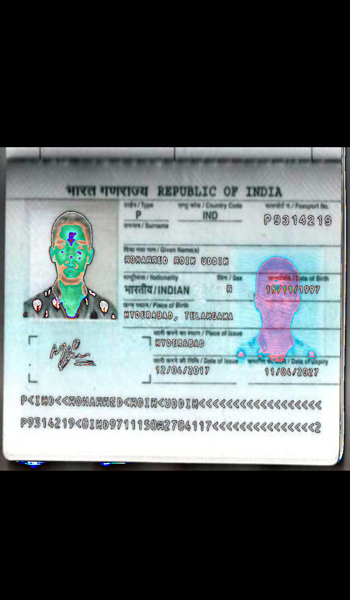

In [ ]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np

# hidde logs
transformers.logging.disable_default_handler()


# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("Sebabrata/dof-passport-1")
model = VisionEncoderDecoderModel.from_pretrained("Sebabrata/dof-passport-1")

# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load random document image from the test set
test_sample = processed_dataset["test"][random.randint(1, 10)]

def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
processor.feature_extractor.to_pil_image(np.array(test_sample["pixel_values"])).resize((350,600))


Reference:
 {'surname': 'SONI', 'place_of_issue': 'CHANDIGARN', 'place_of_birth': ', PUNJAB  KALAN MANJHAL', 'passport_no': '3733700  L', 'nationality': 'INDIAN', 'given_name': 'KARAMJEET SINGH', 'date_of_issue': '15/07/2013', 'date_of_expiry': '14/07/2023', 'date_of_birth': '23/12/1992', 'country_code': 'IND'}
Prediction:
 {'type': 'P', 'surname': 'SOHI', 'place_of_issue': 'CHANDIGARM', 'place_of_birth': 'MANJHAL KALAN, PUNJAB', 'passport_no': 'L3733700', 'nationality': 'INDIAN', 'given_name': 'KARAMJEET SINGH', 'date_of_issue': '15/07/2013', 'date_of_expiry': '14/07/2023', 'date_of_birth': '23/12/1992', 'country_code': 'IND'}


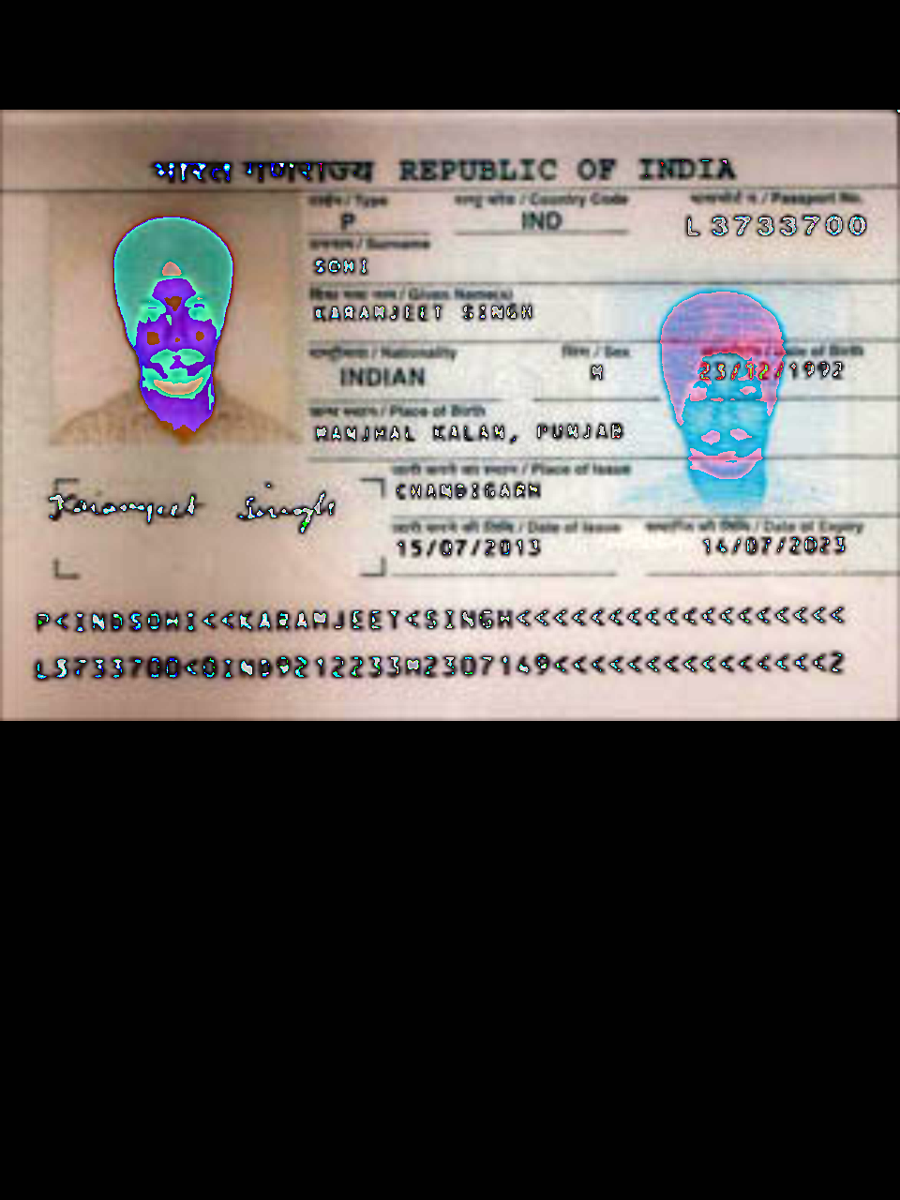

In [ ]:
# Load random document image from the test set
test_sample = processed_dataset["test"][random.randint(1, 10)]
prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
processor.feature_extractor.to_pil_image(np.array(test_sample["pixel_values"])).resize((900,1200))

Reference:
 {'type': 'P', 'surname': 'KATHER MYTHEEN', 'sex': 'M', 'place_of_issue': 'TIRUCHIRAPPALLI', 'place_of_birth': 'TENKASI', 'passport_no': 'G7085001', 'nationality': 'INDIAN', 'given_name': 'BATHUSHA', 'date_of_issue': '12/02/2008', 'date_of_expiry': '11/02/2018', 'date_of_birth': '08/03/1987', 'country_code': 'IND'}
Prediction:
 {'type': 'P', 'surname': 'KATHER MYTHEEN', 'sex': 'M', 'place_of_issue': 'TIRUCHIRAPPALLI', 'place_of_birth': 'TENKASI', 'passport_no': 'G7085001', 'nationality': 'INDIAN', 'given_name': 'BATHUSHA', 'date_of_issue': '12/02/2008', 'date_of_expiry': '11/02/2018', 'date_of_birth': '08/03/1987', 'country_code': 'IND'}


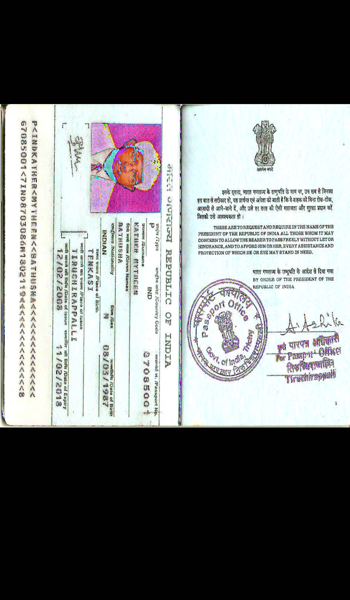

In [ ]:
# Load random document image from the test set
test_sample = processed_dataset["test"][random.randint(1, 10)]
prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
processor.feature_extractor.to_pil_image(np.array(test_sample["pixel_values"])).resize((350,600))

In [ ]:
from tqdm import tqdm

# define counter for samples
true_counter = 0
total_counter = 0

# iterate over dataset
for sample in tqdm(processed_dataset["test"]):
  prediction, target = run_prediction(test_sample)
  for s in zip(prediction.values(), target.values()):
    if s[0] == s[1]:
      true_counter += 1
    total_counter += 1

print(f"Accuracy: {(true_counter/total_counter)*100}%")
# Accuracy: 75.0%


100%|██████████| 20/20 [01:16<00:00,  3.83s/it]

Accuracy: 100.0%
